In [1]:
%load_ext autoreload
%autoreload 2
# import feature_extract
import sys
sys.path.append("..")
import torch
import data_retrieval.psql_methods as psql
import pickle
import data_retrieval.alchemy_methods as alc
from tqdm import tqdm
import numpy as np
from more_itertools import chunked
import pandas as pd
import snob_utils as snob
from scipy.stats import pearsonr, spearmanr

The goal of this notebook is to evaluate how effective aesthetic dissimilarity is at predicting sale value

In [2]:
total_df = snob.create_master_snob_df()
total_df

Loading Data
Loaded Data


100%|██████████| 1184/1184 [00:04<00:00, 249.10it/s]


Loading Data
Loaded Data


100%|██████████| 1265/1265 [00:03<00:00, 318.99it/s]


,Contract,NFT_num,rarity_rank,Label,Collection,sale_price,distance
0,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,102,454.0,0,0-project,0.096525,0.490676
1,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,103,496.0,0,0-project,0.038415,0.368442
2,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,104,218.0,0,0-project,0.034688,0.512769
3,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,106,650.0,0,0-project,0.022950,0.542099
4,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,108,865.0,0,0-project,0.035188,0.482177
...,...,...,...,...,...,...,...
468705,0x9c80777cae192e5031c38a0d951c55730ecc3f5e,6614,2888.0,3428,zombieclub-token,1.534742,0.612652
468706,0x9c80777cae192e5031c38a0d951c55730ecc3f5e,6628,18.0,3428,zombieclub-token,2.425428,0.712623
468707,0x9c80777cae192e5031c38a0d951c55730ecc3f5e,6640,1147.0,3428,zombieclub-token,1.253140,0.687746
468708,0x9c80777cae192e5031c38a0d951c55730ecc3f5e,969,4998.0,3428,zombieclub-token,2.493558,0.618565


In [3]:
total_df.to_pickle('/global/scratch/tlundy/NFT_Research/nft_research/snob_effect/dataframes/total_df.pkl')

In [2]:
df1 = snob.save_data_and_features('images','features',True)

before torch load


/global/scratch/tlundy/NFT_Research/nft_research/snob_effect/snob_utils.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load(feature_path)


after torch load
Dataset ReturnIndexDataset
    Number of datapoints: 846346
    Root location: /global/scratch/tlundy/NFT_Research/nft_research/Dino/images_features/images/val
before psql
after psql
after feature list
after dict


In [19]:
total_df = total_df.groupby('Collection').filter(lambda group: len(group) >= 100)
#Keep only rows with rarity ranks
rares = total_df.dropna(subset=['rarity_rank'],inplace=False).groupby('Collection').filter(lambda group: len(group) >= 100)
slug_list = snob.compute_labels_pearson(rares.groupby('Collection'),'rarity_rank',metric='pearson',slug_list = True)
result_df = snob.compute_global_corrs(total_df,norm_type='additive',slug_list=slug_list)
result_df

/global/scratch/tlundy/NFT_Research/nft_venv2/lib/python3.12/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


(-0.027435901741978037, 3.58153435894283e-44)

In [ ]:
snob.compare_r2(total_df,return_slugs=True)
snob.compare_spearman(total_df)

In [ ]:
import numpy as np
import statsmodels.api as sm

# Suppose you have your data in arrays:
# distance, price, rarity (each is an array of the same length)
total_df = total_df.copy()
total_df = total_df.groupby('Collection').filter(lambda group: len(group) >= 100)
#Keep only rows with rarity ranks
df_filtered_rare = total_df.dropna(subset=['rarity_rank'],inplace=False).groupby('Collection').filter(lambda group: len(group) >= 100)
grouped = df_filtered_rare.groupby('Collection')
pos_count = 0
neg_count = 0
for label,group in grouped:
    rarity = group['rarity_rank']
    distance = group['distance']
    price = group['sale_price']
    # 1. Regress distance on rarity
    X = sm.add_constant(rarity)           # add intercept
    model_dist = sm.OLS(distance, X).fit()
    resid_distance = model_dist.resid     # these are the residuals of distance ~ rarity

    # 2. Regress price on rarity
    model_price = sm.OLS(price, X).fit()
    resid_price = model_price.resid       # these are the residuals of price ~ rarity

 
    # 3. Correlate these residuals and get p-value
    r_partial, p_value = pearsonr(resid_distance, resid_price)
    if p_value < 0.05 and r_partial > 0:
        pos_count+=1
        # print(f"Collection: {label}")
        # print(f"Partial correlation (distance, price | rarity): {r_partial:.4f}")
        # print(f"p-value: {p_value:.4g}")
    if p_value < 0.05 and r_partial < 0:
        neg_count+=1
print(pos_count,neg_count)


In [ ]:

total_df

In [5]:
command = "Select contract,token_id,rank from nft_to_rarity_2"
rarities = psql.execute_commands([command])
# print(rarities)
# Column names for the DataFrame
columns = ['Contract', 'NFT_num', 'rarity_rank']
# Create a DataFrame from the list of tuples
df_rare = pd.DataFrame(rarities, columns=columns)
merged_df_rare = pd.merge(df_rare, total_df, on=['Contract','NFT_num'])

In [ ]:
merged_df = pd.merge(total_df, df_rare, on=columns_to_compare, how='outer', indicator=True)

# Filter rows that are only in df1
coll_to_rare = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1)
coll_to_rare = coll_to_rare.groupby('Collection').filter(lambda group: len(group) >= 100)
coll_to_rare['Collection'].value_counts()

In [ ]:

import statistics
total_df = total_df.groupby('Collection').filter(lambda group: len(group) >= 100)
rares = total_df.dropna(subset=['rarity_rank']).groupby('Collection').filter(lambda group: len(group) >= 100)
grouped = rares.groupby('Collection')
# grouped = coll_to_rare.groupby('Collection')
# Create a scatter plot using Matplotlib
pos_count = 0
neg_count = 0
total_count = 0


correlations = []
for label, group in tqdm(grouped):
    if label in rows:
        total_count+=1
        x = group['rarity_rank']
        y = group['sale_price']
        def statistic(x):  # explore all possible pairings by permuting `x`
            rs = stats.spearmanr(x, y).statistic  # ignore pvalue
            transformed = rs * np.sqrt(dof / ((rs+1.0)*(1.0-rs)))
            return transformed
        # try:
    
        # except:
        #     continue
        # plt.show()
        # Compute correlation coefficient and p-value
        correlation, p_value = pearsonr(x, y)
        
        # correlation, p_value = spearmanr(x,y)
        # ref = stats.permutation_test((x,), statistic, alternative='greater',permutation_type='pairings')
        if p_value<0.05 and correlation>0:
            correlations.append(correlation)
            plt.scatter(x,y,alpha=0.2)
            coefficients = np.polyfit(x, y, 1)
            line_of_best_fit = np.polyval(coefficients, x)
            # Plot the line of best fit
            plt.plot(x, line_of_best_fit, color='red', label='Line of Best Fit')
            plt.title('Scatter Plot')
            plt.xlabel('Column 1')
            plt.xlim(left=0,right=1)
            plt.ylim(top=1,bottom=0)
            plt.ylabel('Column 2')
            # plt.show()
            pos_count+=1
            print(f"Collection: {label}, Correlation: {correlation}, P-Value:{p_value}")
        elif p_value<0.05 and correlation<0:
            neg_count+=1
print(total_count)
print(pos_count)
print(neg_count)
print(np.percentile(correlations,[5,25,50,75,95]))
print(np.mean(correlations))

In [ ]:
pfp_rows = df1.query(f"Collection in {rows}")
selected_columns = pfp_rows[['Contract', 'NFT_num']].to_numpy().tolist()
# rares_to_grab  = list(chunked(selected_columns,10_000))
# for rare_chunk in rares_to_grab:
#     rarities = alc.NFT_to_rarities(rare_chunk)
#     command = "INSERT INTO nft_to_rare (contract, token_id, rarity) VALUES (%s, %s, %s) returning token_id"
#     psql.batch_insert(command,rarities)

In [ ]:
merged_df_rare.query("Collection=='0n1-force'").sort_values('distance')
# merged_df_rare

In [ ]:
df_filtered_rare = merged_df_rare.groupby('Collection').filter(lambda group: len(group) >= 100)
# Count occurrences of each unique label in the filtered DataFrame
label_counts = df_filtered_rare['Collection'].value_counts()

# Display the result
print("Label counts:")
print(label_counts)

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
grouped = df_filtered_rare.groupby('Collection')
# Create a scatter plot using Matplotlib
count=0
count_dist = 0
count_rare = 0
count_dist_neg = 0
count_rare_neg = 0
for label, group in tqdm(grouped):
    if label in dist_slugs:
        x_1 = group['rarity_rank']
        x_2 = group['distance']
        y = group['sale_price']
        dof = dof = len(x_1)-2
        def statistic(x):  # explore all possible pairings by permuting `x`
            rs = stats.spearmanr(x, y).statistic  # ignore pvalue
            transformed = rs * np.sqrt(dof / ((rs+1.0)*(1.0-rs)))
            return transformed
        count+=1
        # Compute correlation coefficient and p-value
        # correlation, p_value = pearsonr(x_1, y)
        # correlation_2, p_value_2 = pearsonr(x_2, y)
        ref = stats.permutation_test((x_1,), statistic, alternative='less',permutation_type='pairings')
        correlation, p_value = spearmanr(x_1, y)
        correlation_2, p_value_2 = spearmanr(x_2, y)
        p_value = stats.permutation_test((x_1,), statistic, alternative='less',permutation_type='pairings').pvalue
        p_value_2 = stats.permutation_test((x_2,), statistic, alternative='greater',permutation_type='pairings').pvalue
        print(p_value)
        print(p_value_2)
        if np.abs(correlation)>np.abs(correlation_2) and p_value<0.05:
        # if p_value<0.05:
            if correlation<-0:
                print(f"(Rarity) Collection: {label}, Correlation: {correlation}, P-Value:{p_value}")
                count_rare_neg+=1
            else:
                print(f"(Rarity) Collection: {label}, Correlation: {correlation}, P-Value:{p_value}")
                count_rare+=1
        elif p_value_2<0.05:
            if correlation_2<0:
                count_dist_neg+=1
            else:
                count_dist+=1
print(count)
print(f"Rare: {count_rare}, Rare Neg: {count_rare_neg}, Dist: {count_dist}, Dist Neg:{count_dist_neg}")

In [ ]:
from sklearn.metrics import r2_score
from sklearn import datasets, linear_model
grouped = df_filtered_rare.groupby('Collection')
# Create a scatter plot using Matplotlib
count=0
count_dist = 0
count_rare = 0
count_dist_neg = 0
count_rare_neg = 0
rare_r2s = []
dist_r2s = []
dist_slugs = []
for label, group in tqdm(grouped):
    # if label not in rows:
    x_1 = -np.asarray(group['rarity_rank'])
    x_1 = x_1.reshape(-1, 1)
    x_2 = np.asarray(group['distance'])
    x_2 = x_2.reshape(-1, 1)
    y = np.asarray(group['sale_price'])
    y = y.reshape(-1, 1)
    # y = np.log10(y, out=np.zeros_like(y), where=(y!=0))
    # Create linear regression object for rarity
    regr1 = linear_model.LinearRegression(positive=True)
    regr1.fit(x_1, y)
    rarity_pred = regr1.predict(x_1)
    # Create linear regression object for rarity
    regr2 = linear_model.LinearRegression(positive=True)
    regr2.fit(x_2, y)
    visual_pred = regr2.predict(x_2)
    # Compute correlation coefficient and p-value
    rare_r2 = r2_score(y,rarity_pred)
    # rare_r2s.append(rare_r2)
    dist_r2= r2_score(y,visual_pred)
    # dist_r2s.append(dist_r2)
    if max(rare_r2,dist_r2) ==0:
        continue
    if rare_r2>dist_r2:
        count_rare+=1
        rare_r2s.append(rare_r2)
    else:
        print(f"(Visual) Collection: {label}, R2: {dist_r2}")
        count_dist+=1
        dist_slugs.append(label)
        dist_r2s.append(dist_r2)
print(count_rare,count_dist,np.mean(rare_r2s),np.mean(dist_r2s))

In [ ]:
from sklearn.metrics import r2_score
from sklearn import datasets, linear_model
grouped = df_filtered_rare.groupby('Collection')
# Create a scatter plot using Matplotlib
count=0
count_dist = 0
count_rare = 0
count_dist_neg = 0
count_rare_neg = 0
rare_r2s = []
dist_r2s = []
for label, group in tqdm(grouped):
    x_1 = -np.asarray(group['rarity_rank'])
    x_1 = x_1.reshape(-1, 1)
    x_2 = np.asarray(group['distance'])
    x_2 = x_2.reshape(-1, 1)
    y = np.asarray(group['sale_price'])
    y = y.reshape(-1, 1)
    combined_array = np.hstack((x_1, x_2))
    # y = np.log10(y, out=np.zeros_like(y), where=(y!=0))
    # Create linear regression object for rarity
    regr1 = linear_model.LinearRegression()
    regr1.fit(combined_array, y)
    rarity_pred = regr1.predict(combined_array)
    # Create linear regression object for rarity
    # Compute correlation coefficient and p-value
    rare_r2 = r2_score(y,rarity_pred)
    rare_r2s.append(rare_r2)
    # dist_r2= r2_score(y,visual_pred)
    # dist_r2s.append(dist_r2)
    if rare_r2>0.1:
        count_rare+=1
    # elif regr2.coef_>0 and dist_r2>0.2:
    #     count_dist+=1
print(count_rare,np.median(rare_r2s))

In [ ]:
with open('rarity_distance.pkl','wb') as f:
    pickle.dump(df_filtered_rare,f)

In [ ]:
with open('rarity_distance.pkl','rb') as f:
    df_filtered_rare = pickle.load(f)

In [ ]:

# Count occurrences of each unique label in the filtered DataFrame
label_counts = df_filtered_rare['rarity'].value_counts()

# Display the result
print("Label counts:")
print(label_counts)

In [ ]:
df_filtered_rare.query("Collection=='sakura-park'").sort_values('rarity_rank')

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
grouped = df_filtered_rare.groupby('Collection')
# Create a scatter plot using Matplotlib
count=0
count_dist = 0
count_rare = 0
count_dist_neg = 0
count_rare_neg = 0
for label, group in tqdm(grouped):
    x_1 = 1-group['rarity']
    y = group['sale_price']
    # Compute correlation coefficient and p-value
    correlation, p_value = pearsonr(x_1, y)
    if p_value<0.05:
        x_1 = np.log(x_1)
        plt.scatter(x_1,y,alpha=0.2,label='Rarity')
        plt.title('Scatter Plot')
        plt.xlabel('Column 1')
        # plt.xlim(left=0,right=1)
        plt.ylabel('Column 2')
        try:
            coefficients = np.polyfit(x_1, y, 1)
            line_of_best_fit = np.polyval(coefficients, x_1)
            # Plot the line of best fit
            plt.plot(x_1, line_of_best_fit, color='red', label='Line of Best Fit')
        except:
            continue
        plt.legend()
        plt.show()
        
        count+=1
        print(f"(Rarity) Collection: {label}, Correlation: {correlation}, P-Value:{p_value}")

In [ ]:
beans_df = merged_df2.query("Collection=='beanzofficial'")

In [ ]:
beans_df.sort_values(by="distance")

In [ ]:
import Openseas_Methods as opse
shit_list = []
for contract,token in tqdm(selected_columns[:10]):
    if contract in shit_list:
        continue
    rarity = opse.pull_nft_rarity(contract,token)
    if rarity is None:
        shit_list.append(contract)
    else:
        print(rarity)


In [ ]:
columns_to_compare = ['Contract', 'NFT_num']

# Merge DataFrames based on specified columns
merged_df = pd.merge(total_df, df_rare, on=columns_to_compare, how='outer', indicator=True)

# Filter rows that are only in df1
coll_to_rare = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1)
coll_to_rare

In [ ]:
selected_columns = sorted(coll_to_rare[['Contract', 'NFT_num']].to_numpy().tolist())
command = "INSERT INTO nft_to_rarity_2 (contract, token_id, rare_score, rank) VALUES (%s, %s, %s,%s) returning token_id"
rares_to_grab  = list(chunked(selected_columns,5000))
rarities = []
print(len(rares_to_grab))
bad_contracts = []
for rare_chunk in rares_to_grab[1:]:
    for contract,token_id in tqdm(rare_chunk):
        if contract in bad_contracts:
            continue
        rare_dict = opse.pull_nft_rarity(contract,token_id)
        if rare_dict is None:
            bad_contracts.append(contract)
            continue
        rarities.append((contract,token_id,rare_dict.get('score',''),rare_dict.get('rank',-1)))
    psql.batch_insert(command,rarities)
    rarities = []

In [ ]:
print('poo')

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy import stats
import statistics
grouped = total_df.groupby('Collection')
# grouped = coll_to_rare.groupby('Collection')
# Create a scatter plot using Matplotlib
pos_count = 0
neg_count = 0
total_count = 0

corr_map = {}
correlations = []
for label, group in tqdm(grouped):
    if label not in rows:
        total_count+=1
        x = group['rarity_rank']
        y = group['sale_price']
        def statistic(x):  # explore all possible pairings by permuting `x`
            rs = stats.spearmanr(x, y).statistic  # ignore pvalue
            transformed = rs * np.sqrt(dof / ((rs+1.0)*(1.0-rs)))
            return transformed
        # try:

        # except:
        #     continue
        # plt.show()
        # Compute correlation coefficient and p-value
        correlation, p_value = pearsonr(x, y)
        corr_map[label] = (correlation,p_value)
        # correlation, p_value = spearmanr(x,y)
        # ref = stats.permutation_test((x,), statistic, alternative='greater',permutation_type='pairings')
        if p_value<0.05 and correlation>0:
            correlations.append(correlation)
            plt.scatter(x,y,alpha=0.2)
            coefficients = np.polyfit(x, y, 1)
            line_of_best_fit = np.polyval(coefficients, x)
            # Plot the line of best fit
            plt.plot(x, line_of_best_fit, color='red', label='Line of Best Fit')
            plt.title('Scatter Plot')
            plt.xlabel('Column 1')
            plt.xlim(left=0,right=1)
            plt.ylim(top=1,bottom=0)
            plt.ylabel('Column 2')
            # plt.show()
            pos_count+=1
            # print(f"Collection: {label}, Correlation: {correlation}, P-Value:{p_value}")
        elif p_value<0.05 and correlation<0:
            neg_count+=1
print(total_count)
print(pos_count)
print(neg_count)
print(np.percentile(correlations,[5,25,50,75,95]))
print(np.mean(correlations))

In [42]:
merged_df_rareq = merged_df_rare.query("Collection=='invazers'")


In [ ]:
import matplotlib.pyplot as plt

# Plot for distance_quantile and sale_price_quantile
plt.figure(figsize=(10, 6))
plt.scatter(merged_df_rareq['distance_quantile'], merged_df_rareq['sale_price_quantile'],alpha=0.1)
plt.xlabel('Distance Quantile')
plt.ylabel('Sale Price Quantile')
plt.title('Sale Price Quantile vs Distance Quantile')
plt.show()

# Plot for rarity_rank_quantile and sale_price_quantile
plt.figure(figsize=(10, 6))
plt.scatter(merged_df_rareq['rarity_rank_quantile'], merged_df_rareq['sale_price_quantile'],alpha=0.1)
plt.xlabel('Rarity Rank Quantile')
plt.ylabel('Sale Price Quantile')
plt.title('Sale Price Quantile vs Rarity Rank Quantile')
plt.show()

In [ ]:
import pandas as pd
import numpy as np

merged_df_rare = merged_df_rare.query("sale_price<100")
merged_df_rare['rarity_rank_quantile'] = merged_df_rare.groupby('Collection')['rarity_rank'].transform(lambda x: x.rank(pct=True))
merged_df_rare['sale_price_quantile'] = merged_df_rare.groupby('Collection')['sale_price'].transform(lambda x: x.rank(pct=True))
merged_df_rare['distance_quantile'] = merged_df_rare.groupby('Collection')['distance'].transform(lambda x: x.rank(pct=True))
# Create 100 buckets for 'distance_quantile' and 'rarity_quantile'
merged_df_rare['distance_quantile_bucket'] = pd.cut(merged_df_rare['distance_quantile'], bins=np.linspace(0, 1, 51))
merged_df_rare['rarity_quantile_bucket'] = pd.cut(merged_df_rare['rarity_rank_quantile'], bins=np.linspace(0, 1, 51))
# Calculate the average 'sale_price_quantile' in each 'distance_quantile' bucket
average_sale_price_in_distance_bucket = merged_df_rare.groupby('distance_quantile_bucket')['sale_price'].mean()

# Calculate the average 'sale_price_quantile' in each 'rarity_quantile' bucket
average_sale_price_in_rarity_bucket = merged_df_rare.groupby('rarity_quantile_bucket')['sale_price'].mean()


# Calculate the standard deviation of 'sale_price_quantile' in each 'distance_quantile' bucket
std_dev_in_distance_bucket = merged_df_rare.groupby('distance_quantile_bucket')['sale_price'].std()

# Calculate the standard deviation of 'sale_price_quantile' in each 'rarity_quantile' bucket
std_dev_in_rarity_bucket = merged_df_rare.groupby('rarity_quantile_bucket')['sale_price'].std()

# Plot for average sale price quantile in each distance quantile bucket with error bars
plt.figure(figsize=(10, 6))
average_sale_price_in_distance_bucket.plot(kind='line')
plt.xlabel('Distance Quantile Bucket')
plt.ylabel('Average Sale Price Quantile')
plt.title('Average Sale Price Quantile for each Distance Quantile Bucket')
plt.xticks(rotation=45)
plt.show()

# Plot for average sale price quantile in each rarity quantile bucket with error bars
plt.figure(figsize=(10, 6))
average_sale_price_in_rarity_bucket.plot(kind='line')
plt.xlabel('Rarity Quantile Bucket')
plt.ylabel('Average Sale Price Quantile')
plt.title('Average Sale Price Quantile for each Rarity Quantile Bucket')
plt.xticks(rotation=45)
plt.show()

In [ ]:
merged_df_rare

In [ ]:
corr_map
with open('../bandwagon/tuples_labels_df.pkl','rb') as f:
    error_map = pickle.load(f)
error_map["Average Error"] = error_map.groupby("Actual")["Error"].transform("mean")
error_map = error_map.groupby('Label').mean().reset_index()
error_map

In [58]:
#make corr map in a df with columns label, correlation, p-value
corr_df = pd.DataFrame(corr_map).T.reset_index()
corr_df.columns = ['Label','correlation','p_value']
corr_df
#merge with error map on Label
merged_df = pd.merge(corr_df,error_map,on='Label')
merged_df["relative error"] = merged_df["Error"]/ merged_df["Average Error"]

In [ ]:
#plot scatter of error vs correlation
merged_df = merged_df.query("p_value<0.05")
plt.scatter(merged_df['correlation'],merged_df["relative error"],alpha=0.5)
print(spearmanr(merged_df['correlation'],merged_df['relative error']))

# plt.xlabel('Correlation')
# plt.ylabel('Error')
plt.title('Error vs Correlation')
plt.show()

In [ ]:
merged_df['residual error'].isinf().sum()

In [ ]:
merged_df.sort_values('relative error',ascending=False).head(10)

In [50]:
total_df = snob.load_master_df()
total_df

,Contract,NFT_num,rarity_rank,Label,Collection,sale_price,distance
0,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,102,454.0,0,0-project,0.096525,0.490676
1,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,103,496.0,0,0-project,0.038415,0.368442
2,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,104,218.0,0,0-project,0.034688,0.512769
3,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,106,650.0,0,0-project,0.022950,0.542099
4,0x69be2c18a3c7acd14d5114a66f2dad3e96150427,108,865.0,0,0-project,0.035188,0.482177
...,...,...,...,...,...,...,...
468705,0x9c80777cae192e5031c38a0d951c55730ecc3f5e,6614,2888.0,3428,zombieclub-token,1.534742,0.612652
468706,0x9c80777cae192e5031c38a0d951c55730ecc3f5e,6628,18.0,3428,zombieclub-token,2.425428,0.712623
468707,0x9c80777cae192e5031c38a0d951c55730ecc3f5e,6640,1147.0,3428,zombieclub-token,1.253140,0.687746
468708,0x9c80777cae192e5031c38a0d951c55730ecc3f5e,969,4998.0,3428,zombieclub-token,2.493558,0.618565


In [51]:
#pearson correlation between rarity and price not grouped
total_df = total_df.dropna(subset=['rarity_rank'])
price = total_df['sale_price']
rarity = total_df['rarity_rank']
correlation, p_value = pearsonr(rarity, price)
print(f"Correlation: {correlation}, P-Value: {p_value}")


Correlation: 0.0029983536149826937, P-Value: 0.07052334248105147


/tmp/ipykernel_78620/1988522177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df['avg_price'] = total_df.groupby('Collection')['sale_price'].transform('mean')
/tmp/ipykernel_78620/1988522177.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df['rarity_quantile'] = total_df.groupby('Collection')['rarity_rank']\
/tmp/ipykernel_78620/1988522177.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Correlation (normalized by collection): 0.007899587902478883, P-Value: 1.8894314610217105e-06
Correlation (additive normalization): -0.01878655564996098, P-Value: 9.050767064981885e-30
Correlation (multiplicative normalization): 0.11779498184925305, P-Value: 0.0


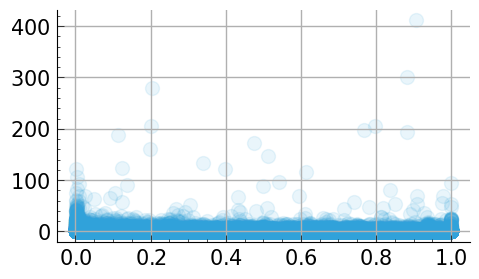

In [62]:
import matplotlib.pyplot as plt
total_df['avg_price'] = total_df.groupby('Collection')['sale_price'].transform('mean')
total_df['rarity_quantile'] = total_df.groupby('Collection')['rarity_rank']\
                                      .rank(method='dense', pct=True)
# 3. Create a new column with the normalized price (price / average price of that collection)
total_df['add_normalized_price'] = total_df['sale_price'] + (total_df['avg_price']+1e-12)
total_df['mult_normalized_price'] = total_df['sale_price'] / (total_df['avg_price']+1e-12)
# total_df_filt = total_df.query("mult_normalized_price<1000000")
# 4. Compute Pearson correlation between rarity and the normalized price
correlation, p_value = spearmanr(-total_df_filt['rarity_quantile'], total_df_filt['sale_price'])
correlation_mult, p_value_mult = spearmanr(-total_df_filt['rarity_quantile'], total_df_filt['mult_normalized_price'])
correlation_add, p_value_add = spearmanr(-total_df_filt['rarity_quantile'], total_df_filt['add_normalized_price'])
# 5. Print or store the result
spearmanr
print(f"Correlation (normalized by collection): {correlation}, P-Value: {p_value}")
print(f"Correlation (additive normalization): {correlation_add}, P-Value: {p_value_add}")
print(f"Correlation (multiplicative normalization): {correlation_mult}, P-Value: {p_value_mult}")
#plot correlation between rarity and price
plt.scatter(total_df_filt['rarity_quantile'],total_df_filt['mult_normalized_price'],alpha=0.1)

In [46]:
total_df['rarity_quantile']

0         0.375000
1         0.500000
2         0.125000
3         0.625000
4         1.000000
            ...   
468705    0.475309
468706    0.003086
468707    0.175926
468708    0.904321
468709    0.024691
Name: rarity_quantile, Length: 358405, dtype: float64